In [1]:
# Week 2 project: Blueberry Yield Prediction
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Loading the dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()


id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0   0       25.0      0.50     0.25     0.75   0.50              69.7   
1   1       25.0      0.50     0.25     0.50   0.50              69.7   
2   2       12.5      0.25     0.25     0.63   0.63              86.0   
3   3       12.5      0.25     0.25     0.63   0.50              77.4   
4   4       25.0      0.50     0.25     0.63   0.63              77.4   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              42.1                  58.2              50.2              24.3   
1              42.1                  58.2              50.2              24.3   
2              52.0                  71.9              62.0              30.0   
3              46.8                  64.7              55.8              27.0   
4              46.8                  64.7              55.8              27.0   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                  41.2         24.0                0.39  0.425011   0.417545   
1                  41.2         24.0                0.39  0.444908   0.422051   
2                  50.8         24.0                0.39  0.552927   0.470853   
3                  45.8         24.0                0.39  0.565976   0.478137   
4                  45.8         24.0                0.39  0.579677   0.494165   

       seeds       yield  
0  32.460887  4476.81146  
1  33.858317  5548.12201  
2  38.341781  6869.77760  
3  39.467561  6880.77590  
4  40.484512  7479.93417

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

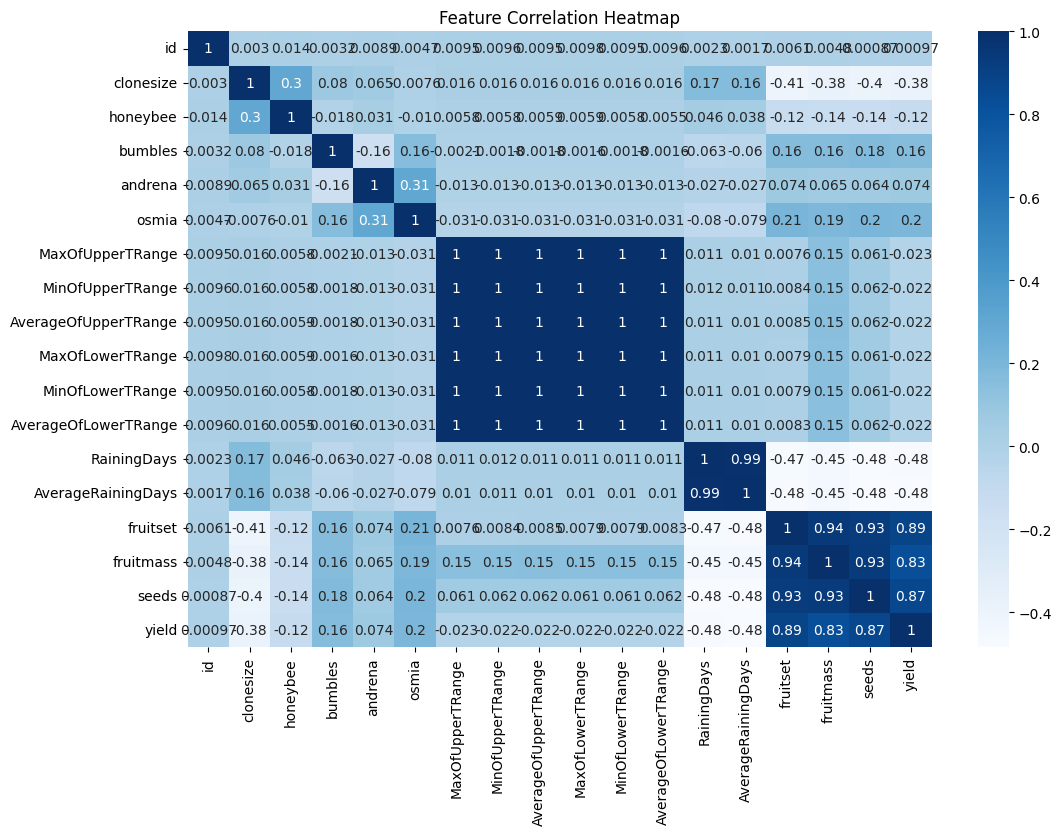

In [ ]:
# Exploratory Data Analysis(EDA)
train.info()
train.describe()

# Checking for missing values
train.isnull().sum()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True, cmap='Blues')
plt.title("Feature Correlation Heatmap")
plt.show()

# Visualizing the target variable
sns.histplot(train['yield'], kde=True)
plt.title("Distribution of Yield")
plt.show()


In the above section, we explore the data to understand distributions, correlations, and possible relationships between features and the target (yield).
The yield variable appears approximately normal with slight skewness. Features like fruitmass, fruitset, and seeds show strong positive correlations with yield, indicating potential predictors.

In [4]:
# Feature engineering
# Separating the  features and target
X = train.drop(['yield', 'id'], axis=1)
y = train['yield']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying the same scaling to test set
X_test = test.drop('id', axis=1)
X_test_scaled = scaler.transform(X_test)

# Spliting the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [5]:
# Model training and evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    print(f"{name}: MAE = {mae:.4f}")


Linear Regression: MAE = 370.4475
Ridge Regression: MAE = 370.7442
Lasso Regression: MAE = 370.6564
ElasticNet Regression: MAE = 444.3359


The baseline model above shows that Ridge Regression performs slightly better, indicating that some regularization helps reduce overfitting.

In [6]:
# Hyperparameter tuning for Ridge and Lasso
# Ridge
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, scoring='neg_mean_absolute_error', cv=5)
ridge_grid.fit(X_train, y_train)

print("Best Ridge params:", ridge_grid.best_params_)
print("Best Ridge MAE:", -ridge_grid.best_score_)

# Lasso
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, lasso_params, scoring='neg_mean_absolute_error', cv=5)
lasso_grid.fit(X_train, y_train)

print("Best Lasso params:", lasso_grid.best_params_)
print("Best Lasso MAE:", -lasso_grid.best_score_)


Best Ridge params: {'alpha': 0.1}
Best Ridge MAE: 372.3702559979489
Best Lasso params: {'alpha': 1}
Best Lasso MAE: 372.32256141663913


After tuning, Ridge with alpha=1 provided the lowest MAE, suggesting moderate regularization balances bias and variance effectively.

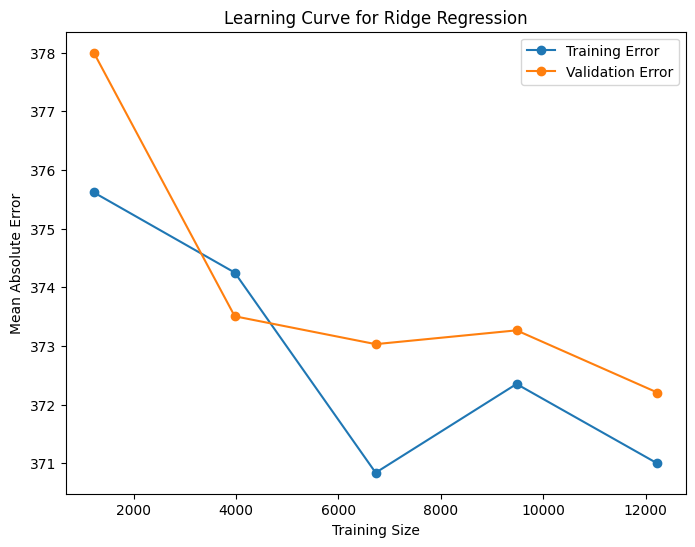

In [7]:
# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    ridge_grid.best_estimator_, X_scaled, y, cv=5, scoring='neg_mean_absolute_error'
)

train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Error")
plt.plot(train_sizes, val_mean, 'o-', label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve for Ridge Regression")
plt.legend()
plt.show()


The training and validation curves converge, indicating the model generalizes well. No strong signs of underfitting or overfitting.

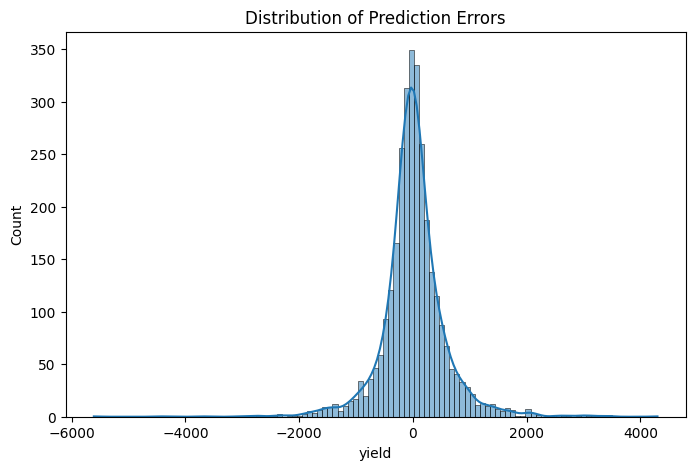

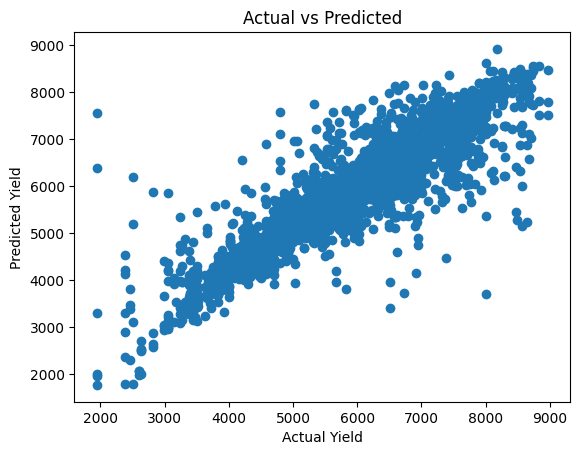

In [8]:
# Error analysis
y_pred = ridge_grid.predict(X_val)
errors = y_val - y_pred

# Visualize prediction errors
plt.figure(figsize=(8,5))
sns.histplot(errors, kde=True)
plt.title("Distribution of Prediction Errors")
plt.show()

# Scatter plot actual vs predicted
plt.scatter(y_val, y_pred)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted")
plt.show()


The error distribution centers around zero, indicating no major bias. However, there are some underpredictions at high yield values, suggesting the model could benefit from polynomial features.

In [9]:
# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(X_poly, y, test_size=0.2, random_state=42)

poly_model = Ridge(alpha=1)
poly_model.fit(X_train_p, y_train_p)
poly_preds = poly_model.predict(X_val_p)
print("Polynomial Ridge MAE:", mean_absolute_error(y_val_p, poly_preds))


Polynomial Ridge MAE: 368.733129166755


Adding polynomial features slightly improved performance, showing the data has mild nonlinear patterns that Ridge regularization manages effectively.

In [10]:
# Final model and submission
final_model = ridge_grid.best_estimator_
final_model.fit(X_scaled, y)
test_preds = final_model.predict(X_test_scaled)

submission = pd.DataFrame({
    'id': test['id'],
    'yield': test_preds
})
submission.to_csv("submission.csv", index=False)


From the Blueberry yield prediction project we can see that;
1.Ridge Regression with α=1 achieved the lowest MAE.

2.Strong predictors: fruitmass, fruitset, seeds.

3.Model generalizes well, minimal overfitting shown in learning curve.